# Module 1 Final Project
- Overview of homes within King County of Seattle Washington

_by: Rahkeem D. George_

## Objective

The goal of this project is to give average home buyers some insigt on buying homes within the King County in Seattle, Washington

## Outline

* [Custom-functions](#Custom-functions)
* [Data Cleaning](#Data-Cleaning)
* [Data Conditioning](#Data-Conditioning)
* [Data Visualization](#Data-Vizualization)
* [Model Creation & Validation](#Model-Creation-&-Validation)
    - [Experiment 1:](#Experiment-1:)
    - [Experiment 2:](#Experiment-2:)
    - [Experiment 3:](#Experiment-3:)
    - [Experiment 4:](#Experiment-4:)
    - [Post feature engineering](#Post-feature-engineering)
* [Cross Validation](#Cross-Validation)
    - [Experiment 1 Model without the constant](#Experiment-1-Model-without-the-constant)
    - [Experiment 1 Model with the constant](#Experiment-1-Model-with-the-constant)
* [Post Validation](#Post-Validation)
* [Conclusion](#Conclusion)
* [Recommendations](#Recommendations)

In [1]:
import pandas as pd
import seaborn as sbn
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from statsmodels.formula.api import ols
from scipy import stats
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

%matplotlib inline

df = pd.read_csv('./kc_house_data.csv')

#### __Custom functions__

In [2]:
##################################
## Data Manipulation Functions ##
#################################
def find_null(df):
    return df[df.isnull().any(axis=1)]

def drop_columns (df, list_to_drop):
    """
    This function takes in a data frame and the list of labels, or columns to drop within the dataframe and returns a new dataframe
    with the drop columns removed

    df: Data frame or array type object
    list_to_drop: list of labels to remove from the frame object
    """
    drop_df = df.drop(list_to_drop, axis=1)
    return drop_df

def use_columns(df, list_to_use):

    new_df = df[list_to_use]
    return new_df

##################################
## Graphing & Plotting function ##
##################################

def make_residual_plot(residuals):
    # create x-values for residual plot
    x = np.linspace(0, 1, len(residuals))
    
    #plot residuals
    plt.figure(figsize=(13, 8))
    plt.scatter(x, residuals, alpha=0.75, c='k')
    plt.title('Residuals')
    plt.hlines(y=0, colors='r', xmin=0, xmax=1, linewidth=3)
    plt.show()

def scatter_plot(X, Y, a=0.75, title='', x_label='', y_label=''):
        plt.title(title)
        plt.scatter(x=X, y=Y, alpha=a)
        plt.xlabel(x_label)
        plt.ylabel(y_label)
        plt.legend()
        plt.show()

def make_hist(df, col=None, figsize=(15,15)):
    if not col:
        df.hist(figsize=figsize)
    else:
        df.hist(figsize=figsize, column=col)
    plt.show()
    
def scatter_matrix(df, alpha=0.75, color='g'):
    pd.plotting.scatter_matrix(df, figsize=(20,20), alpha=alpha, c=color)
    plt.show()
    
def heatmap(df):
    plt.figure(figsize=(20,20))
    sbn.heatmap(df.corr(), cmap=sbn.color_palette('Blues'), annot=True, fmt='0.2g')
    plt.show()

#####################################################
## Functions for transformations & feature scaling ##
#####################################################

def min_max2(srs):
    return (srs - min(srs))/(max(srs) - min(srs))

def min_max(df, lbl_col):
    return (df[lbl_col] - min(df[lbl_col]))/(max(df[lbl_col]) - min(df[lbl_col]))

def mean_norm2(srs):
    return (srs - np.mean(srs))/np.sqrt(np.var(srs))

def mean_norm(df, lbl_col):
    return (df[lbl_col] - np.mean(df[lbl_col]))/np.sqrt(np.var(df[lbl_col]))

def unit_vec2(srs):
    return (srs)/(np.linalg.norm(srs))

def unit_vec(df, lbl_col):
    return (df[lbl_col])/(np.linalg.norm(df[lbl_col]))

def log_trans2(srs):
    return np.log(srs)

def log_trans(df, lbl_col):
    return np.log(df[lbl_col])

#######################################################
## Models, Feature Selection, & Validation Functions ##
#######################################################

def feat_rank_cval(df=df, columns_to_use=None, target='price', n=4, use_intercept=True):
    """
    The purpose of this function is to return the list of features that have received the best score 
    within the feature ranking method of sk.learn and to run a cross validation on those features.  
    The information returned is a list of features that the program has determined to be the best ones to use for a model
    
    The function will also print out the mean of the R-squared cross validation test values.
    Three rounds of cross validations are ran.
    
    The mean of the R-squared values are printed.
    
    1st uses 10 segments
    2nd uses 20 segments
    3rd uses 50 segments
    
    Parameters:
    -----------
    df:  Pandas dataframe object containing the features used for predictions and the target
    
    columns to use: The list of the the feature names|columns within the dataframe to use 
    
    target: The column that you are attempting to predict
    
    n: The number of features that should be returned during the ranking procedure. 
    
    use_intercept: Boolean variable that tells the function to use the fit-intercept, or not to use it.
    
    Returns:
    --------
    feat_czn:  A dictionary with the features selected. Will return only those features that have been selected 
        
        Key:   The label, or name, of the feature
        
        Value: A boolean value.  True - feature selected   False - feature NOT selected
    """
    if not columns_to_use:
        print('Columns not set. Using the dataframe passed as an argument')
        X = df
    else:
        X = use_columns(df, list_to_use=to_use)

    y = df[target]

    # code to run the Feature Ranking with Recursive Feature Elimination
    linreg = LinearRegression(fit_intercept=use_intercept)
    selector = RFE(linreg, n_features_to_select=n)
    selector = selector.fit(X, y)

    selector.support_
    selector.ranking_

    estimators = selector.estimator_
    
    # Dictionary of selected features, identified by boolean
    feat_czn = {k : v for k, v, in zip(X.columns, selector.support_) if v==True}
    
    print(f'Feature Ranking with Cross Validation')
    print('---------------------------------------')
    print(f'\nFeatures Chosen: {feat_czn}')
    
    # Print the coefficients  and the intercept of the features selected
    print(f'Coeff: {estimators.coef_}')
    print(f'Y-incercept: {estimators.intercept_}')

    #Cross Validation Code
    cv_10_results = np.mean(cross_val_score(linreg, X, y, cv=10, scoring="r2"))
    cv_20_results = np.mean(cross_val_score(linreg, X, y, cv=20, scoring="r2"))
    cv_50_results = np.mean(cross_val_score(linreg, X, y, cv=50, scoring="r2"))

    # Results of the cross validation
    print(f'\nResults of cross validation tests:'.upper())
    print(f'Cross Validaation with 10: {cv_10_results}')
    print(f'Cross Validaation with 20: {cv_20_results}')
    print(f'Cross Validaation with 50: {cv_50_results}')
    
    print(f'\n\n')
    
    return feat_czn

def make_ols_model(df=df,target='price', predictors=None, add_constant=True):
    """
    Parameters:
    -----------
    
    df : pandas Dataframe with all features and the target included 
    
    target: The feature that we are trying to test our model against.  
            Set to a default of 'price' for the sake of this project.
            Can change to another if needed
    
    predictors: The features that we want to run in our models to predict the target
    
    add_constant: Boolean to signal that we are adding a constant to our OLS model.
                  Possible values: True or False
                  
    Returns:
    ---------
    ols : The OLS model used to predict y against X
    
    results : 
    
    """
    X = df[predictors]
    y = df[target]

    #By default, add constant to X values 
    if add_constant:
        X = sm.add_constant(X)
    ols = sm.OLS(y, X)
    results = ols.fit()
    print(results.summary())
    
    return ols, results

def forward_selected(data, response):
    """Linear model designed by forward selection.

    Parameters:
    -----------
    data : pandas DataFrame with all possible predictors and response

    response: string, name of response column in data

    Returns:
    --------
    model: an "optimal" fitted statsmodels linear model
           with an intercept
           selected by forward selection
           evaluated by adjusted R-squared
           
    https://planspace.org/20150423-forward_selection_with_statsmodels/
    """
    remaining = set(data.columns)
    remaining.remove(response)
    selected = []
    current_score, best_new_score = 0.0, 0.0
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:
            formula = "{} ~ {} + 1".format(response,
                                           ' + '.join(selected + [candidate]))
            score = smf.ols(formula, data).fit().rsquared_adj
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates.pop()
        if current_score < best_new_score:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
    formula = "{} ~ {} + 1".format(response,
                                   ' + '.join(selected))
    model = smf.ols(formula, data).fit()
    return model

def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included


#### ---End of custom function list---

In [3]:
# Get the dimensions of the data frame
# house_df.shape
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
id               21597 non-null int64
date             21597 non-null object
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       19221 non-null float64
view             21534 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null object
yr_built         21597 non-null int64
yr_renovated     17755 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: float64(8), int64(11), object(2)
memory usage: 3.5+ MB


## Data Cleaning

In this section, alterations are made to some of our data colums
* `sqft_basement` had values of `?` instead of a number.  These values were replaced with zeros
* `date` was converted to a date object and reassigned within the dataframe
* `yr_renovated` - _**year renovated**_ was dropped due to large ammounts of missing info & 0 for dates not listed
* Filled `NaN` & null values with -1. for `view` & `waterfront`  
   * This will be a sign that some info was not present

In [4]:
# Data cleaning for sqft_basement
df.sqft_basement.replace('?', 0, inplace=True)
df.sqft_basement = df.sqft_basement.astype('float')

# Convert date field to a date type
df['date'] = pd.to_datetime(df['date'])

# Fill null waterfront values with -1
df.waterfront.fillna(-1, inplace=True)

# Drop feature 'yr_renovated' since this column is missing a large ammount of data
df.drop(labels='yr_renovated', inplace=True, axis=1)

# Fill null view values with -1.  Retaining this info for later use
df.view.fillna(-1, inplace=True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 20 columns):
id               21597 non-null int64
date             21597 non-null datetime64[ns]
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       21597 non-null float64
view             21597 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null float64
yr_built         21597 non-null int64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: datetime64[ns](1), float64(8), int64(11)
memory usage: 3.3 MB


## Data Conditioning 

In this section, the goal is to see which features have normal distributions and which ones do not.
For those that do not, we will apply techniques to make the distributions more normal

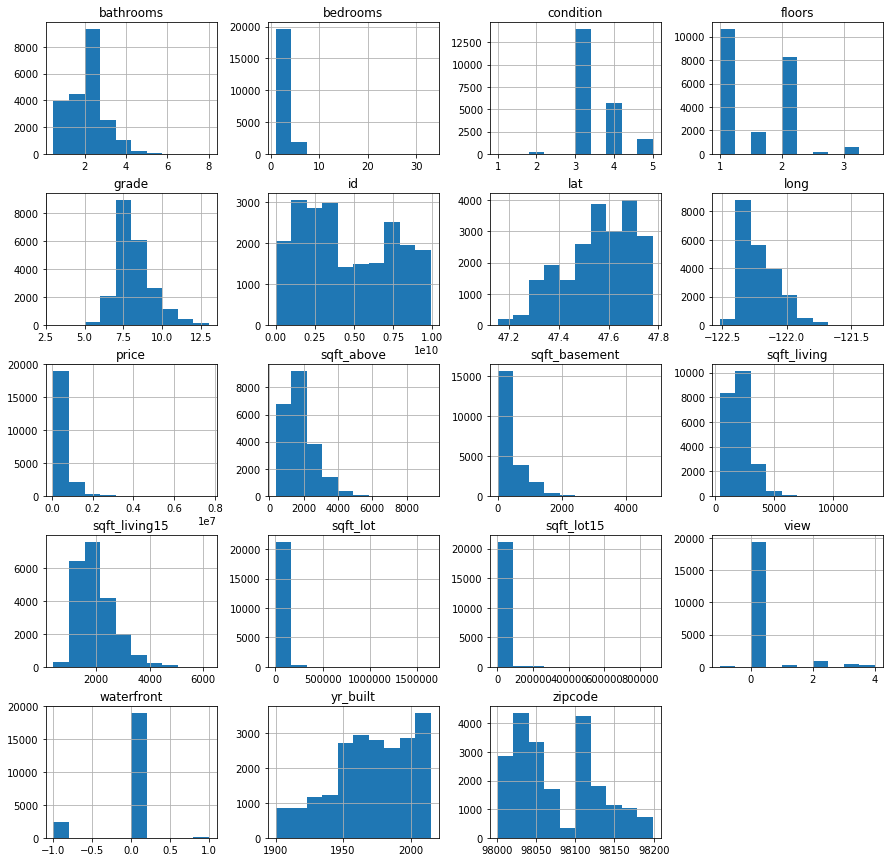

In [6]:
make_hist(df)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 20 columns):
id               21597 non-null int64
date             21597 non-null datetime64[ns]
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       21597 non-null float64
view             21597 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null float64
yr_built         21597 non-null int64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: datetime64[ns](1), float64(8), int64(11)
memory usage: 3.3 MB


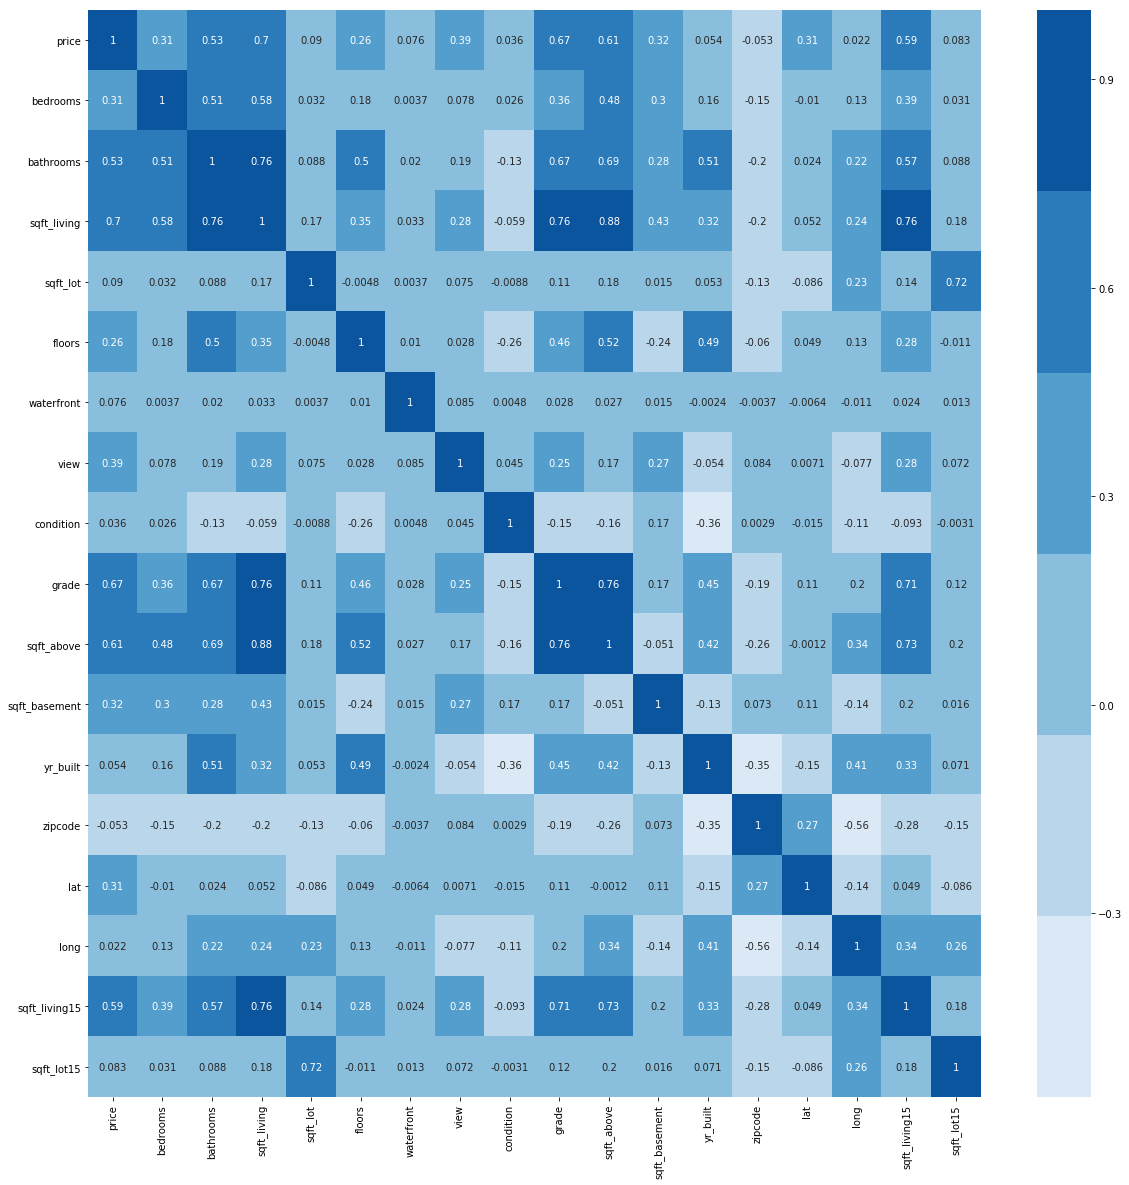

In [8]:
heatmap(drop_columns(df, list_to_drop=['id', 'date']))

## Data Visualization

In this sections, we will be taking a look at some of the different features and how they relate to one another:

In the table below is a general overview of some main features of the houses within King County.

* Most of the houses have 1 floor
* The average price of homes within this area have an average price of $540,296.00

In [9]:
df[['price', 'yr_built','grade', 'condition', 'bathrooms', 'bedrooms', 'sqft_living', 'sqft_lot', 'floors']].describe()

,price,yr_built,grade,condition,bathrooms,bedrooms,sqft_living,sqft_lot,floors
count,2.159700e+04,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,2.159700e+04,21597.000000
mean,5.402966e+05,1970.999676,7.657915,3.409825,2.115826,3.373200,2080.321850,1.509941e+04,1.494096
std,3.673681e+05,29.375234,1.173200,0.650546,0.768984,0.926299,918.106125,4.141264e+04,0.539683
min,7.800000e+04,1900.000000,3.000000,1.000000,0.500000,1.000000,370.000000,5.200000e+02,1.000000
25%,3.220000e+05,1951.000000,7.000000,3.000000,1.750000,3.000000,1430.000000,5.040000e+03,1.000000
50%,4.500000e+05,1975.000000,7.000000,3.000000,2.250000,3.000000,1910.000000,7.618000e+03,1.500000
75%,6.450000e+05,1997.000000,8.000000,4.000000,2.500000,4.000000,2550.000000,1.068500e+04,2.000000
max,7.700000e+06,2015.000000,13.000000,5.000000,8.000000,33.000000,13540.000000,1.651359e+06,3.500000


### _How does the grade of a home compare to the price?_

The grade of a house is a ranking of how good the building standards are.  The grade system runs on a scale from 1 up to 13, where 13 generally reffers to custom mansions, with a high level of quality.

Based on the information that is present in our dataset, we are able to see how prices and locations go hand in hand

_House locations by price_

Most of the costly homes tend to be in the northern part fo King County.

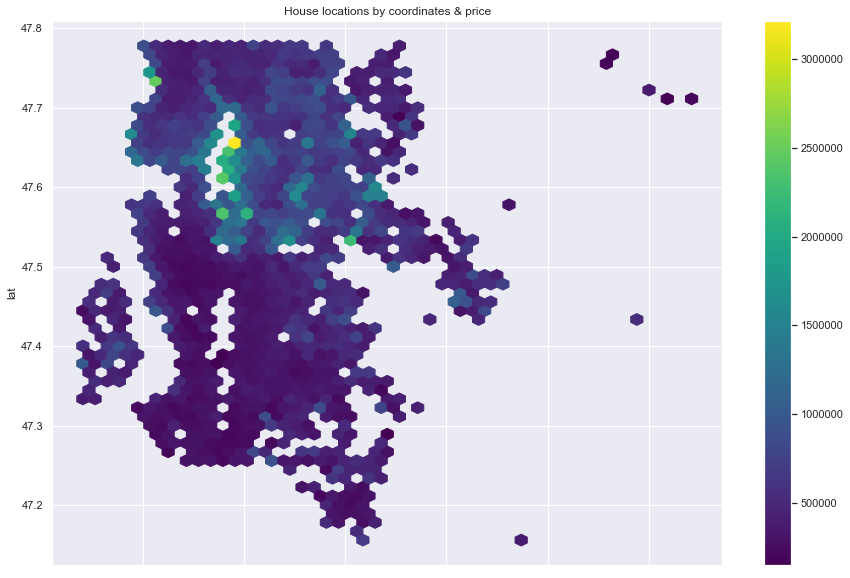

In [35]:
df.plot.hexbin(figsize=(15, 10), x='long', y='lat', C='price', gridsize=50, cmap='viridis')
plt.title('House locations by coordinates & price')
plt.show()

_Houses by grade_

In this section, we also took a look at the locations of the houses and what the grade attach to them look like.

Most of the houses have an average grade of over 7.  Within the grade scale, 7 is average.  
An average grade is a good one.  It means that the building structure is well above the minimum building standards.

You will not have to worry about a home being safe for yourself or a family, when decididng to purchase in this area

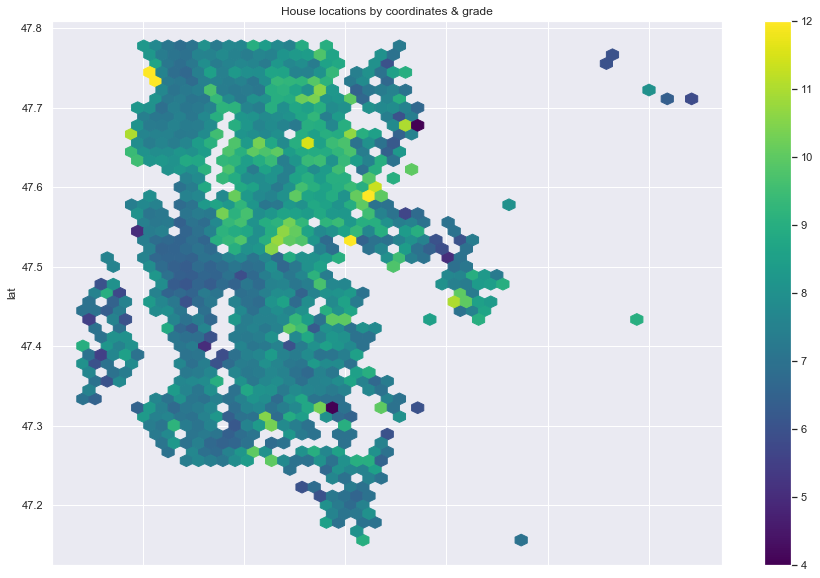

In [36]:
df.plot.hexbin(figsize=(15, 10), x='long', y='lat', C='grade', gridsize=50, cmap='viridis')
plt.title('House locations by coordinates & grade')
plt.show()

_House distribution boxplot with outliers_

These are the homes by grade & price with outliers included.  Those outliers significantly impact the overall look and feel of our data.  In the next image, we will remove them to get a better sense of what the majority of home prices are

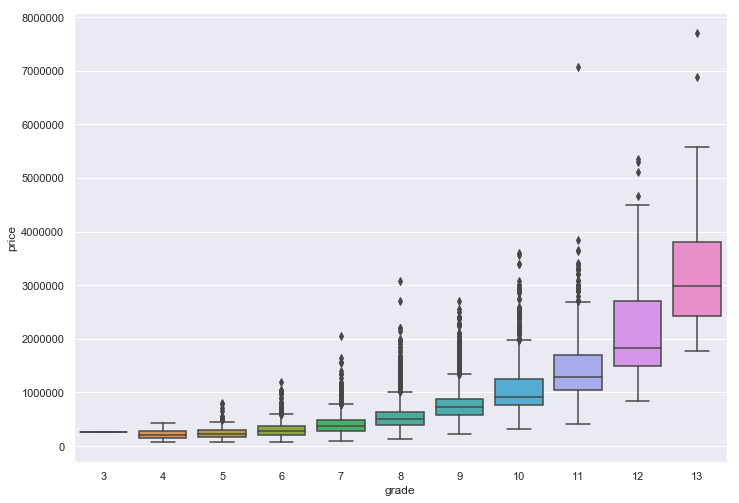

In [12]:
sbn.set(rc={'figure.figsize':(11.7,8.27)})
sbn.boxplot(x=df.grade, y=df.price)

_House distribution without outliers_

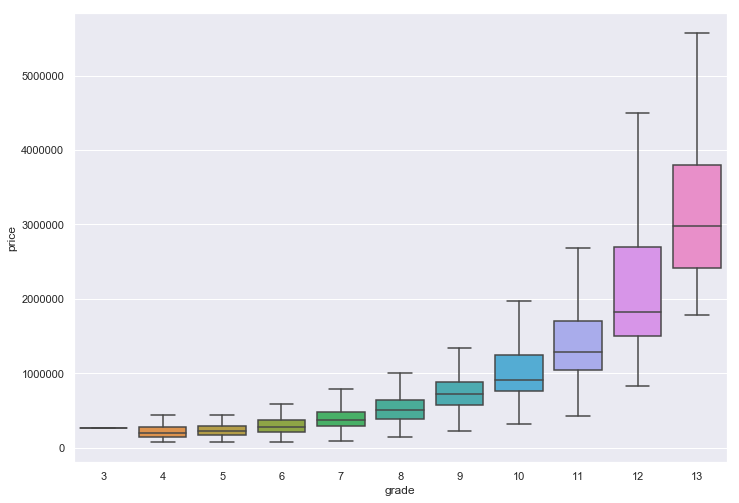

In [13]:
sbn.set(rc={'figure.figsize':(11.7,8.27)})
sbn.boxplot(x=df.grade, y=df.price, showfliers=False)

## Model Creation & Validation

In this section, I have created several models, using different techniques to find the best combination of features with the least ammount of features being dropped.  

To condense the length of the notebook, I have only included the most sucessful combination of features for the model I used.  

__Trial & Error: My personal features selection__

With this model, I chose to use following features:
`views`, `condition`, `sqft_above`*, & `lat`*.

    Transformation and feature scalings were applied to `Lat` & `sqft_above` in attempt to better enhance these featues for the models to predict the price.
 

Most of these were dropped as a result of highly linear relations with other features.

**`Date` & `id`**  were removed mainly because they did not improve the information on houses themselves.                    
They are identifiers of the houses sold and when they were sold.

_Feature transformation & selection_

The code below implements some common feature transformations 

In [14]:
df['log_sqft_above'] = log_trans2(df.sqft_above)
df['uv_log_sqft_above'] = unit_vec2(df.log_sqft_above)
df['mm_log_sqft_above'] = min_max2(df.log_sqft_above)
df['log_lat'] = log_trans2(df.lat)
df['log_zipcode'] = log_trans2(df.zipcode)

# Transforming Long to a positive value by negating its sign, perform a log transformation, then reapply the negative
df['ng_log_long'] = np.negative(log_trans2(np.abs(df.long)))

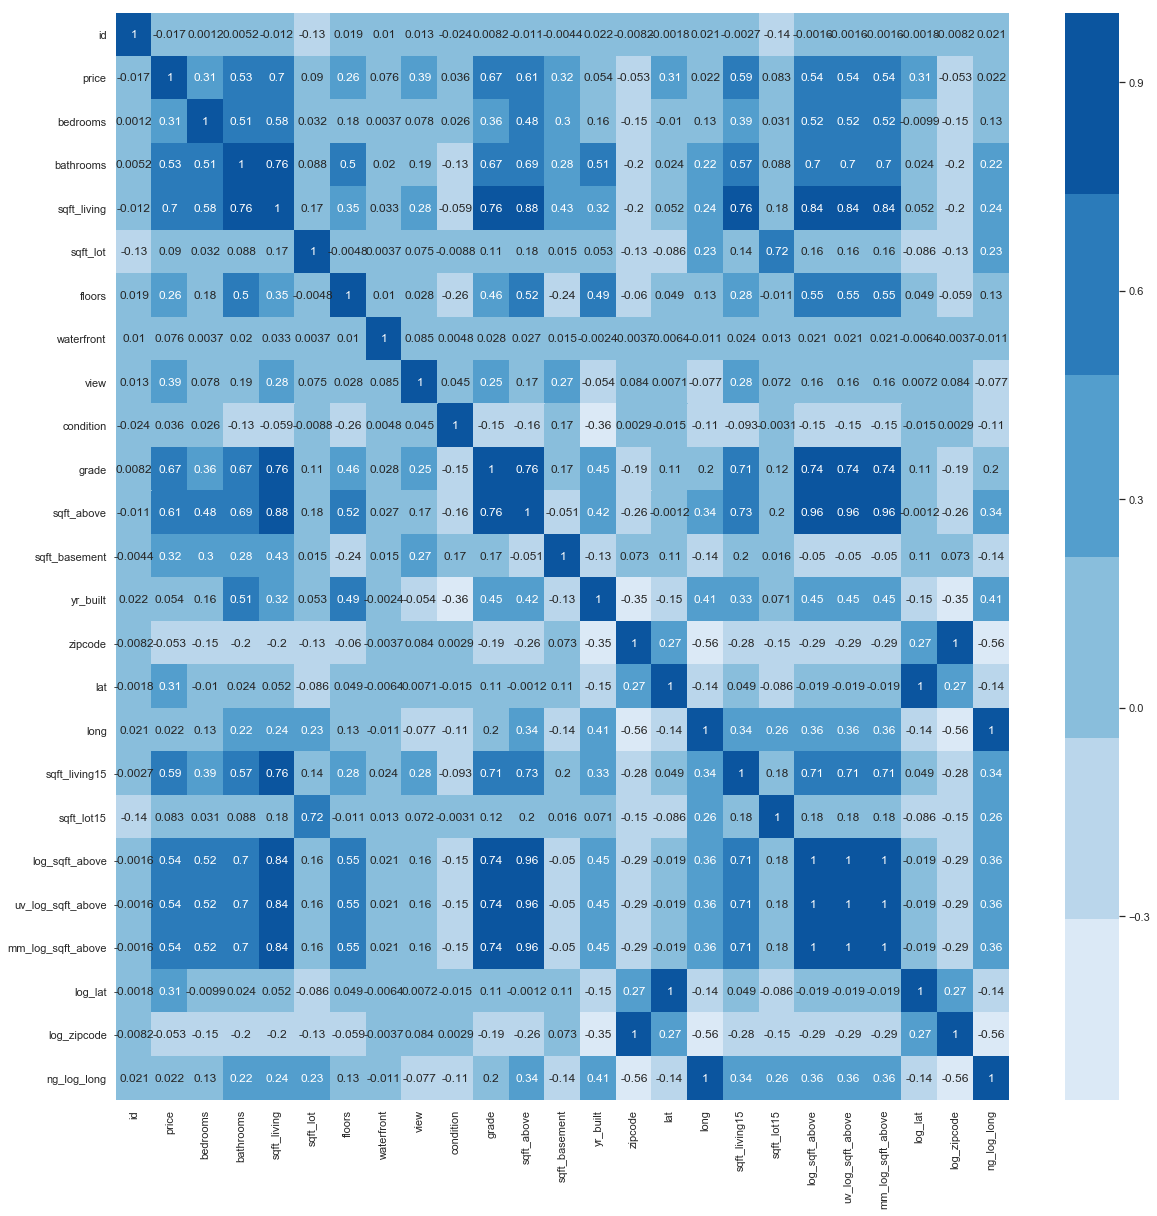

In [15]:
heatmap(df=df)

#### Testing to find a strong model for predictions ####

In this section, I tried using some different featrues to see hwo they will work together in makig a strong model.

#### _Experiment 1:_

_These are the features that I chose to use_

In [16]:
columns = ['view', 'condition', 'mm_log_sqft_above', 'log_lat']
model1, results1 = make_ols_model(df=df, predictors=columns, add_constant=False)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.810
Model:                            OLS   Adj. R-squared:                  0.810
Method:                 Least Squares   F-statistic:                 2.305e+04
Date:                Sun, 29 Sep 2019   Prob (F-statistic):               0.00
Time:                        19:00:49   Log-Likelihood:            -3.0188e+05
No. Observations:               21597   AIC:                         6.038e+05
Df Residuals:                   21593   BIC:                         6.038e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
view               1.471e+05   2561.49

#### Experiment 2: ####
In this experiment, the condition number is to high and removes this combination of features as an option

In [17]:
columns = ['view', 'condition', 'uv_log_sqft_above', 'ng_log_long']
model2, results2 = make_ols_model(df=df, predictors=columns, add_constant=False)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.810
Model:                            OLS   Adj. R-squared:                  0.810
Method:                 Least Squares   F-statistic:                 2.305e+04
Date:                Sun, 29 Sep 2019   Prob (F-statistic):               0.00
Time:                        19:00:49   Log-Likelihood:            -3.0188e+05
No. Observations:               21597   AIC:                         6.038e+05
Df Residuals:                   21593   BIC:                         6.038e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
view               1.471e+05   2561.39

#### _Experiment 3:_ ####

This one was not a viable option due to the large condition number, although the R-squared value is very high

In [18]:
columns = ['view', 'condition', 'ng_log_long', 'log_lat', 'log_sqft_above']
model3, results3 = make_ols_model(df=df, predictors=columns, add_constant=False)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.834
Model:                            OLS   Adj. R-squared:                  0.834
Method:                 Least Squares   F-statistic:                 2.171e+04
Date:                Sun, 29 Sep 2019   Prob (F-statistic):               0.00
Time:                        19:00:49   Log-Likelihood:            -3.0043e+05
No. Observations:               21597   AIC:                         6.009e+05
Df Residuals:                   21592   BIC:                         6.009e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
view            1.512e+05   2396.355     63.

#### _Experiment 4:_ ####

The condition number is pretty good for this one, as well as the `p-values` and the `R-squared` value.

The condition is slightly higher than that of _Experiment 1,_ but it is a very similar model.

In [19]:
columns = ['view', 'condition', 'ng_log_long', 'log_sqft_above']
model4, results4 = make_ols_model(df=df, predictors=columns, add_constant=False)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.810
Model:                            OLS   Adj. R-squared:                  0.810
Method:                 Least Squares   F-statistic:                 2.305e+04
Date:                Sun, 29 Sep 2019   Prob (F-statistic):               0.00
Time:                        19:00:49   Log-Likelihood:            -3.0188e+05
No. Observations:               21597   AIC:                         6.038e+05
Df Residuals:                   21593   BIC:                         6.038e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
view            1.471e+05   2561.395     57.

#### _Post feature engineering_


Most of my other test involved different variations of using engineered features
One attempt included inverting the sign of the longitude, applying a log transformation, and reassinging the negative.

In addition, I also applied feature scalings, suc as min-max, mean normalization, and unit vector. 

The results of these transformations were very similar to the main features that I chose to use for my model:

`view`, `condition`, `mm_log_sqft_above`, & `log_lat`
    

### Cross Validation ###

During the selection process of the features, the constant tend to cause issues with the R-squared calculation.


In the selection below, I ran the model with the selected features with & without the constant added to show the diffence in the calculated value.

Note that the model with the constant, though it generated a better r-squared value than the model without the constant, performed worse on the cross validation than the model with the constant.


#### _Experiment 1 Model without the constant_ ####

In [20]:
to_use = ['view', 'condition', 'mm_log_sqft_above', 'log_lat']  # features I chose. Experiment 1

feat_rank_cval(df=df, columns_to_use=to_use, n=len(to_use), use_intercept=False)

Feature Ranking with Cross Validation
---------------------------------------

Features Chosen: {'view': True, 'condition': True, 'mm_log_sqft_above': True, 'log_lat': True}
Coeff: [ 147062.73885067   55078.6926467  1415227.56117338  -85257.33134291]
Y-incercept: 0.0

RESULTS OF CROSS VALIDATION TESTS:
Cross Validaation with 10: 0.39760980896450426
Cross Validaation with 20: 0.39791838581525407
Cross Validaation with 50: 0.395652652712549





{'view': True, 'condition': True, 'mm_log_sqft_above': True, 'log_lat': True}

#### _Experiment 1 Model with the constant_ ####

In [21]:
to_use = ['view', 'condition', 'log_sqft_above', 'log_lat']  # features I chose

feat_rank_cval(df=df, columns_to_use=to_use, n=4, use_intercept=True)

Feature Ranking with Cross Validation
---------------------------------------

Features Chosen: {'view': True, 'condition': True, 'log_sqft_above': True, 'log_lat': True}
Coeff: [  145196.29210244    59325.91768756   444758.6349459  39851642.52471299]
Y-incercept: -156891119.90650505

RESULTS OF CROSS VALIDATION TESTS:
Cross Validaation with 10: 0.4992966773542708
Cross Validaation with 20: 0.5005976841676116
Cross Validaation with 50: 0.5016094089642303





{'view': True, 'condition': True, 'log_sqft_above': True, 'log_lat': True}

### Post Validation ###
After seeing the performance of the model generated in experiment 1, we will now check the residuals from our model in _Experiment 1_ to see what can be removed to help improve our results

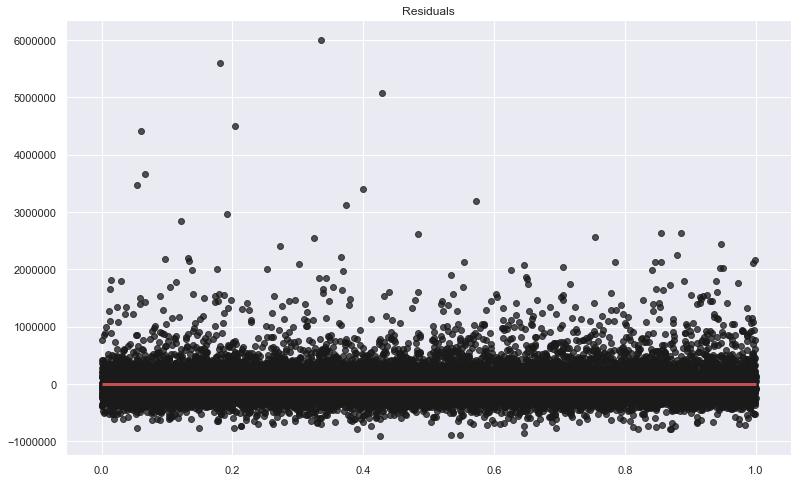

In [22]:
#Residuals from Experiment 1 Model 
make_residual_plot(results1.resid)

In [23]:
drop_resid_ind = np.where(results1.resid > 1000000)[0]
drop_resid_ind

df_trimmed1 = df.drop(index=drop_resid_ind)

Running the Model from _Experiment 1_ again, with the residuals removed:

In [24]:
model_rev1, results_rev1 = make_ols_model(df=df_trimmed1, predictors=to_use, add_constant=False)

feat_rank_cval(df=df_trimmed1, columns_to_use=to_use, n=len(to_use), use_intercept=False)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.861
Model:                            OLS   Adj. R-squared:                  0.861
Method:                 Least Squares   F-statistic:                 3.307e+04
Date:                Sun, 29 Sep 2019   Prob (F-statistic):               0.00
Time:                        19:00:51   Log-Likelihood:            -2.9343e+05
No. Observations:               21378   AIC:                         5.869e+05
Df Residuals:                   21374   BIC:                         5.869e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
view            1.169e+05   2056.850     56.

{'view': True, 'condition': True, 'log_sqft_above': True, 'log_lat': True}

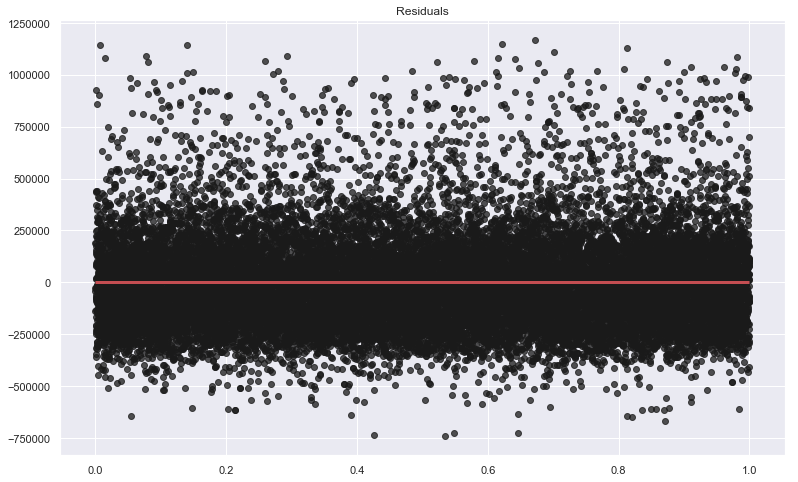

In [25]:
make_residual_plot(results_rev1.resid)

More residuals could be removed in theory, but continuing to remove them may not improve the cross validation test, by a significant ammount.

## Conclusion ##

Making a model to accruately predict what housing prices will be can be very complicated.

With the tools at our disposal, we were able to engineer the avilable features and create a model that looked very promising, but our model did not perform as well as hoped.  

Although the initial R-squared was very high, it was only able to accruately fit 40% of the dataset to the predicted value.


### Recommendations ###
Places where this project could be further improved upon are listed below:
* Tools for better feature engineering
    - The most difficult part of this project was tryign to find a group of features. 
      In the future, I would like to add a tool that would more efficiently go through the features and select the best grouping for predictions
* More data to test with
    - The performance of the model was interesting to witness, since the model was created using the dataset itself.  
    - If possible, I believe that having more data to test & validate the model will help in the validation stage.